In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation, Multiply
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import Sequence

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
from tensorflow.keras.layers import Layer, Dense, Activation, Multiply, Lambda
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(name='att_var', 
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        # Score calculation for each time step
        score = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch_size, timesteps, features)
        score = K.dot(score, self.V)  # (batch_size, timesteps, 1)
        attention_weights = K.softmax(score, axis=1)  # (batch_size, timesteps, 1)
        
        # Multiply each time step by its attention weight
        context_vector = inputs * attention_weights  # (batch_size, timesteps, features)
        context_vector = K.sum(context_vector, axis=1)   # (batch_size, features)
        return context_vector

# Convenience function to use the layer
def attention_layer(inputs):
    return AttentionLayer()(inputs)


In [5]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an improved Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building improved model...")

    # Spatial Feature Extractor
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")

    # Temporal Analysis with LSTM (Improved)
    lstm_input = Input(shape=(None, 512), name="lstm_input")

    # First LSTM remains the same:
    lstm_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(lstm_input)
    # Change the second LSTM to output sequences (i.e., 3D tensor)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4))(lstm_out)

    # Now attention_layer receives a 3D tensor as expected
    attn_out = attention_layer(lstm_out)
    attn_out = BatchNormalization()(attn_out)

    output = Dense(1, activation='sigmoid')(attn_out)
    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")

    print("Improved model built successfully.")
    return spatial_model, temporal_model


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    """Trains the model with improved training strategy."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)
    x_test_features = np.expand_dims(x_test_features, axis=1)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Improved Temporal Model (LSTM)...")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

    # Train the LSTM Model
    history = temporal_model.fit(
        x_train_features, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_features, y_test),
        callbacks=[model_checkpoint, early_stopping, lr_reducer]
    )

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

In [6]:
# # Load precomputed dataset
# save_path = "E:/dataset_1/preprocessed_happy.npz"
# print(f"📂 Loading precomputed dataset from {save_path}...")
# data = np.load(save_path)

# # Extract x_data and y_data
# x_data, y_data = data["x"], data["y"]
# print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# # Verify shapes
# print(f"📊 Train/Test Split:")
# print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
# print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

In [7]:



# Create a Sequence wrapper to load batches from the memmap on demand.
class MemmapSequence(Sequence):
    def __init__(self, memmap_array, indices, batch_size=32):
        self.memmap_array = memmap_array
        self.indices = indices
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        # When using fancy indexing on a memmap, a copy is made only for this batch.
        return self.memmap_array[batch_idx]

# --- Data Loading Without Loading Entire Dataset Into RAM ---

# Load the dataset with memory mapping so that the full array isn’t loaded into RAM immediately.
save_path = "E:/dataset_1/preprocessed_angry.npz"
print(f"📂 Loading precomputed dataset from {save_path}...")
data = np.load(save_path, mmap_mode='r')  # memmap; data remains on disk until accessed
x_data, y_data = data["x"], data["y"]
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Use StratifiedShuffleSplit to get train/test indices without forcing a full copy.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(x_data, y_data))

# Sorting indices can help get more contiguous slices.
train_idx = np.sort(train_idx)
test_idx = np.sort(test_idx)

# Instead of slicing x_data (which would copy a 12GB block into memory),
# create Sequences that load data in batches.
batch_size = 32
x_train_seq = MemmapSequence(x_data, train_idx, batch_size=batch_size)
x_test_seq = MemmapSequence(x_data, test_idx, batch_size=batch_size)

# y_data is small so we load it normally.
y_train = y_data[train_idx]
y_test = y_data[test_idx]

print("📊 Train/Test Split:")
print(f"  x_train_seq: {len(x_train_seq)} batches (batch_size={batch_size}), y_train: {y_train.shape}")
print(f"  x_test_seq: {len(x_test_seq)} batches (batch_size={batch_size}), y_test: {y_test.shape}")

# --- Training the Model ---
# Now call your train_model function as before—but pass the Sequence objects instead of full numpy arrays.
# For example:
#
# spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))
# train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test)
#
# Keras model.predict (and model.fit, if needed) supports Sequence objects, so your existing
# build_model() and train_model() functions remain unchanged.


📂 Loading precomputed dataset from E:/dataset_1/preprocessed_angry.npz...
✅ Loaded dataset: 20000 samples.
📊 Train/Test Split:
  x_train_seq: 500 batches (batch_size=32), y_train: (16000,)
  x_test_seq: 125 batches (batch_size=32), y_test: (4000,)


In [8]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# spatial_model.summary()
temporal_model.summary()


Building improved model...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\applications\xception.py:111: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  input_shape = imagenet_utils.obtain_input_shape(



Improved model built successfully.


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 256)      │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │        66,048 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,298,625 (8.77 MB)

 Trainable params: 2,298,113 (8.77 MB)

 Non-trainable params: 512 (2.00 KB)

Extracting features from Xception (Spatial Model)...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 1859s 4s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 463s 4s/step
Training Improved Temporal Model (LSTM)...
Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5098 - loss: 0.6931
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.5098 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 2/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5576 - loss: 0.6920
Epoch 2: val_accuracy improved from 0.50000 to 0.50625, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5577 - loss: 0.6919 - val_accuracy: 0.5063 - val_loss: 0.6885 - learning_rate: 1.0000e-04
Epoch 3/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6276 - loss: 0.6852
Epoch 3: val_accuracy improved from 0.50625 to 0.64950, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6277 - loss: 0.6852 - val_accuracy: 0.6495 - val_loss: 0.6652 - learning_rate: 1.0000e-04
Epoch 4/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6978 - loss: 0.6533
Epoch 4: val_accuracy improved from 0.64950 to 0.65400, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6979 - loss: 0.6533 - val_accuracy: 0.6540 - val_loss: 0.5881 - learning_rate: 1.0000e-04
Epoch 5/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7990 - loss: 0.5432
Epoch 5: val_accuracy improved from 0.65400 to 0.78375, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7991 - loss: 0.5430 - val_accuracy: 0.7837 - val_loss: 0.4444 - learning_rate: 1.0000e-04
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8506 - loss: 0.4014
Epoch 6: val_accuracy improved from 0.78375 to 0.86900, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8506 - loss: 0.4014 - val_accuracy: 0.8690 - val_loss: 0.3198 - learning_rate: 1.0000e-04
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8715 - loss: 0.3234
Epoch 7: val_accuracy improved from 0.86900 to 0.89650, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8715 - loss: 0.3233 - val_accuracy: 0.8965 - val_loss: 0.2671 - learning_rate: 1.0000e-04
Epoch 8/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8776 - loss: 0.2956
Epoch 8: val_accuracy did not improve from 0.89650
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8775 - loss: 0.2956 - val_accuracy: 0.8800 - val_loss: 0.2700 - learning_rate: 1.0000e-04
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8753 - loss: 0.2961
Epoch 9: val_accuracy did not improve from 0.89650
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8753 - loss: 0.2961 - val_accuracy: 0.8942 - val_loss: 0.2570 - learning_rate: 1.0000e-04
Epoch 10/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8779 - loss: 0.2896
Epoch 10: val_accuracy improved from 0.89650 to 0.90175, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8779 - loss: 0.2896 - val_accuracy: 0.9018 - val_loss: 0.2366 - learning_rate: 1.0000e-04
Epoch 11/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8825 - loss: 0.2866
Epoch 11: val_accuracy did not improve from 0.90175
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8825 - loss: 0.2866 - val_accuracy: 0.9013 - val_loss: 0.2346 - learning_rate: 1.0000e-04
Epoch 12/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8796 - loss: 0.2941
Epoch 12: val_accuracy improved from 0.90175 to 0.90300, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8797 - loss: 0.2941 - val_accuracy: 0.9030 - val_loss: 0.2308 - learning_rate: 1.0000e-04
Epoch 13/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8873 - loss: 0.2766
Epoch 13: val_accuracy did not improve from 0.90300
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8873 - loss: 0.2766 - val_accuracy: 0.8852 - val_loss: 0.2806 - learning_rate: 1.0000e-04
Epoch 14/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8830 - loss: 0.2838
Epoch 14: val_accuracy did not improve from 0.90300
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8830 - loss: 0.2838 - val_accuracy: 0.8965 - val_loss: 0.2486 - learning_rate: 1.0000e-04
Epoch 15/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8882 - loss: 0.2753
Epoch 15: val_accuracy improved from 0.90300 to 0.90775, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8882 - loss: 0.2753 - val_accuracy: 0.9078 - val_loss: 0.2195 - learning_rate: 1.0000e-04
Epoch 16/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8851 - loss: 0.2909
Epoch 16: val_accuracy did not improve from 0.90775
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8851 - loss: 0.2908 - val_accuracy: 0.9055 - val_loss: 0.2217 - learning_rate: 1.0000e-04
Epoch 17/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8919 - loss: 0.2675
Epoch 17: val_accuracy did not improve from 0.90775
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8919 - loss: 0.2675 - val_accuracy: 0.9035 - val_loss: 0.2253 - learning_rate: 1.0000e-04
Epoch 18/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8879 - loss: 0.2779
Epoch 18: val_accuracy improved from 0.90775 to 0.91450, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8880 - loss: 0.2779 - val_accuracy: 0.9145 - val_loss: 0.2121 - learning_rate: 1.0000e-04
Epoch 19/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8902 - loss: 0.2659
Epoch 19: val_accuracy did not improve from 0.91450
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8902 - loss: 0.2659 - val_accuracy: 0.9137 - val_loss: 0.2150 - learning_rate: 1.0000e-04
Epoch 20/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8947 - loss: 0.2592
Epoch 20: val_accuracy improved from 0.91450 to 0.91800, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8947 - loss: 0.2592 - val_accuracy: 0.9180 - val_loss: 0.2033 - learning_rate: 1.0000e-04
Epoch 21/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8923 - loss: 0.2748
Epoch 21: val_accuracy improved from 0.91800 to 0.91900, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8923 - loss: 0.2748 - val_accuracy: 0.9190 - val_loss: 0.2002 - learning_rate: 1.0000e-04
Epoch 22/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8971 - loss: 0.2608
Epoch 22: val_accuracy did not improve from 0.91900
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8971 - loss: 0.2608 - val_accuracy: 0.9040 - val_loss: 0.2383 - learning_rate: 1.0000e-04
Epoch 23/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8972 - loss: 0.2547
Epoch 23: val_accuracy did not improve from 0.91900
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8972 - loss: 0.2547 - val_accuracy: 0.9150 - val_loss: 0.2039 - learning_rate: 1.0000e-04
Epoch 24/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8953 - loss: 0.2681
Epoch 24: val_accuracy did not improve from 0.91900
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8953 - loss: 0.2681 - val_accuracy: 0.9057 - val_loss: 0.2170 - learning_rate: 1.

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9032 - loss: 0.2508 - val_accuracy: 0.9252 - val_loss: 0.1865 - learning_rate: 5.0000e-05
Epoch 27/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9041 - loss: 0.2393
Epoch 27: val_accuracy did not improve from 0.92525
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9041 - loss: 0.2393 - val_accuracy: 0.9240 - val_loss: 0.1906 - learning_rate: 5.0000e-05
Epoch 28/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9046 - loss: 0.2426
Epoch 28: val_accuracy did not improve from 0.92525
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9046 - loss: 0.2426 - val_accuracy: 0.9237 - val_loss: 0.1905 - learning_rate: 5.0000e-05
Epoch 29/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9083 - loss: 0.2379
Epoch 29: val_accuracy improved from 0.92525 to 0.92675, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9083 - loss: 0.2379 - val_accuracy: 0.9268 - val_loss: 0.1838 - learning_rate: 5.0000e-05
Epoch 30/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9028 - loss: 0.2400
Epoch 30: val_accuracy did not improve from 0.92675
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9028 - loss: 0.2400 - val_accuracy: 0.9258 - val_loss: 0.1843 - learning_rate: 5.0000e-05
Epoch 31/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9074 - loss: 0.2380
Epoch 31: val_accuracy improved from 0.92675 to 0.92825, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9074 - loss: 0.2380 - val_accuracy: 0.9283 - val_loss: 0.1816 - learning_rate: 5.0000e-05
Epoch 32/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9132 - loss: 0.2353
Epoch 32: val_accuracy improved from 0.92825 to 0.92975, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9132 - loss: 0.2353 - val_accuracy: 0.9298 - val_loss: 0.1765 - learning_rate: 5.0000e-05
Epoch 33/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9125 - loss: 0.2304
Epoch 33: val_accuracy improved from 0.92975 to 0.93175, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9125 - loss: 0.2304 - val_accuracy: 0.9317 - val_loss: 0.1749 - learning_rate: 5.0000e-05
Epoch 34/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9158 - loss: 0.2274
Epoch 34: val_accuracy did not improve from 0.93175
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9158 - loss: 0.2274 - val_accuracy: 0.9280 - val_loss: 0.1757 - learning_rate: 5.0000e-05
Epoch 35/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9076 - loss: 0.2348
Epoch 35: val_accuracy did not improve from 0.93175
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9076 - loss: 0.2348 - val_accuracy: 0.9202 - val_loss: 0.1908 - learning_rate: 5.0000e-05
Epoch 36/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9115 - loss: 0.2259
Epoch 36: val_accuracy improved from 0.93175 to 0.93425, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9115 - loss: 0.2260 - val_accuracy: 0.9342 - val_loss: 0.1698 - learning_rate: 5.0000e-05
Epoch 37/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9139 - loss: 0.2204
Epoch 37: val_accuracy did not improve from 0.93425
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9139 - loss: 0.2204 - val_accuracy: 0.9337 - val_loss: 0.1690 - learning_rate: 5.0000e-05
Epoch 38/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9143 - loss: 0.2297
Epoch 38: val_accuracy improved from 0.93425 to 0.93525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9143 - loss: 0.2296 - val_accuracy: 0.9352 - val_loss: 0.1665 - learning_rate: 5.0000e-05
Epoch 39/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9163 - loss: 0.2215
Epoch 39: val_accuracy improved from 0.93525 to 0.93800, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9163 - loss: 0.2215 - val_accuracy: 0.9380 - val_loss: 0.1658 - learning_rate: 5.0000e-05
Epoch 40/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9120 - loss: 0.2279
Epoch 40: val_accuracy did not improve from 0.93800
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9120 - loss: 0.2279 - val_accuracy: 0.9358 - val_loss: 0.1646 - learning_rate: 5.0000e-05
Epoch 41/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9178 - loss: 0.2127
Epoch 41: val_accuracy improved from 0.93800 to 0.94050, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9178 - loss: 0.2127 - val_accuracy: 0.9405 - val_loss: 0.1621 - learning_rate: 5.0000e-05
Epoch 42/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9134 - loss: 0.2185
Epoch 42: val_accuracy did not improve from 0.94050
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9134 - loss: 0.2185 - val_accuracy: 0.9337 - val_loss: 0.1661 - learning_rate: 5.0000e-05
Epoch 43/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9138 - loss: 0.2206
Epoch 43: val_accuracy improved from 0.94050 to 0.94225, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9138 - loss: 0.2206 - val_accuracy: 0.9423 - val_loss: 0.1589 - learning_rate: 5.0000e-05
Epoch 44/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9221 - loss: 0.2062
Epoch 44: val_accuracy did not improve from 0.94225
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9221 - loss: 0.2062 - val_accuracy: 0.9293 - val_loss: 0.1804 - learning_rate: 5.0000e-05
Epoch 45/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9164 - loss: 0.2207
Epoch 45: val_accuracy did not improve from 0.94225
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9164 - loss: 0.2207 - val_accuracy: 0.9367 - val_loss: 0.1609 - learning_rate: 5.0000e-05
Epoch 46/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9196 - loss: 0.2088
Epoch 46: val_accuracy improved from 0.94225 to 0.94350, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9196 - loss: 0.2088 - val_accuracy: 0.9435 - val_loss: 0.1537 - learning_rate: 5.0000e-05
Epoch 47/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9196 - loss: 0.2037
Epoch 47: val_accuracy did not improve from 0.94350
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9196 - loss: 0.2038 - val_accuracy: 0.9355 - val_loss: 0.1630 - learning_rate: 5.0000e-05
Epoch 48/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9153 - loss: 0.2298
Epoch 48: val_accuracy improved from 0.94350 to 0.94375, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9153 - loss: 0.2297 - val_accuracy: 0.9438 - val_loss: 0.1506 - learning_rate: 5.0000e-05
Epoch 49/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9226 - loss: 0.2139
Epoch 49: val_accuracy did not improve from 0.94375
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9226 - loss: 0.2139 - val_accuracy: 0.9398 - val_loss: 0.1563 - learning_rate: 5.0000e-05
Epoch 50/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9231 - loss: 0.2020
Epoch 50: val_accuracy improved from 0.94375 to 0.94650, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9231 - loss: 0.2020 - val_accuracy: 0.9465 - val_loss: 0.1489 - learning_rate: 5.0000e-05
Epoch 51/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9221 - loss: 0.2099
Epoch 51: val_accuracy did not improve from 0.94650
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9221 - loss: 0.2099 - val_accuracy: 0.9395 - val_loss: 0.1585 - learning_rate: 5.0000e-05
Epoch 52/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9217 - loss: 0.2027
Epoch 52: val_accuracy improved from 0.94650 to 0.94875, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9217 - loss: 0.2027 - val_accuracy: 0.9488 - val_loss: 0.1448 - learning_rate: 5.0000e-05
Epoch 53/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9208 - loss: 0.2142
Epoch 53: val_accuracy did not improve from 0.94875
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9208 - loss: 0.2141 - val_accuracy: 0.9452 - val_loss: 0.1448 - learning_rate: 5.0000e-05
Epoch 54/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9224 - loss: 0.1981
Epoch 54: val_accuracy did not improve from 0.94875
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9224 - loss: 0.1981 - val_accuracy: 0.9463 - val_loss: 0.1429 - learning_rate: 5.0000e-05
Epoch 55/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9244 - loss: 0.2030
Epoch 55: val_accuracy improved from 0.94875 to 0.94900, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9244 - loss: 0.2030 - val_accuracy: 0.9490 - val_loss: 0.1390 - learning_rate: 5.0000e-05
Epoch 56/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9247 - loss: 0.2021
Epoch 56: val_accuracy did not improve from 0.94900
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9246 - loss: 0.2021 - val_accuracy: 0.9427 - val_loss: 0.1502 - learning_rate: 5.0000e-05
Epoch 57/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9213 - loss: 0.2128
Epoch 57: val_accuracy improved from 0.94900 to 0.95225, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9213 - loss: 0.2128 - val_accuracy: 0.9523 - val_loss: 0.1374 - learning_rate: 5.0000e-05
Epoch 58/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9296 - loss: 0.1957
Epoch 58: val_accuracy did not improve from 0.95225
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9296 - loss: 0.1957 - val_accuracy: 0.9445 - val_loss: 0.1481 - learning_rate: 5.0000e-05
Epoch 59/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9242 - loss: 0.2124
Epoch 59: val_accuracy improved from 0.95225 to 0.95425, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9243 - loss: 0.2124 - val_accuracy: 0.9542 - val_loss: 0.1331 - learning_rate: 5.0000e-05
Epoch 60/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9256 - loss: 0.1943
Epoch 60: val_accuracy did not improve from 0.95425
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9256 - loss: 0.1943 - val_accuracy: 0.9470 - val_loss: 0.1428 - learning_rate: 5.0000e-05
Epoch 61/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9261 - loss: 0.2075
Epoch 61: val_accuracy improved from 0.95425 to 0.95625, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9261 - loss: 0.2075 - val_accuracy: 0.9563 - val_loss: 0.1344 - learning_rate: 5.0000e-05
Epoch 62/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9329 - loss: 0.1916
Epoch 62: val_accuracy did not improve from 0.95625
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9329 - loss: 0.1916 - val_accuracy: 0.9540 - val_loss: 0.1294 - learning_rate: 5.0000e-05
Epoch 63/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9276 - loss: 0.1966
Epoch 63: val_accuracy did not improve from 0.95625
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9276 - loss: 0.1966 - val_accuracy: 0.9485 - val_loss: 0.1390 - learning_rate: 5.0000e-05
Epoch 64/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9332 - loss: 0.1894
Epoch 64: val_accuracy did not improve from 0.95625
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9332 - loss: 0.1895 - val_accuracy: 0.9545 - val_loss: 0.1277 - learning_rate: 5.00

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9272 - loss: 0.1957 - val_accuracy: 0.9580 - val_loss: 0.1309 - learning_rate: 5.0000e-05
Epoch 66/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9295 - loss: 0.1978
Epoch 66: val_accuracy did not improve from 0.95800
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9295 - loss: 0.1978 - val_accuracy: 0.9565 - val_loss: 0.1300 - learning_rate: 5.0000e-05
Epoch 67/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9308 - loss: 0.1858
Epoch 67: val_accuracy did not improve from 0.95800
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9308 - loss: 0.1858 - val_accuracy: 0.9572 - val_loss: 0.1225 - learning_rate: 5.0000e-05
Epoch 68/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9351 - loss: 0.1846
Epoch 68: val_accuracy improved from 0.95800 to 0.96050, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9351 - loss: 0.1846 - val_accuracy: 0.9605 - val_loss: 0.1228 - learning_rate: 5.0000e-05
Epoch 69/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9293 - loss: 0.1929
Epoch 69: val_accuracy improved from 0.96050 to 0.96075, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9293 - loss: 0.1929 - val_accuracy: 0.9607 - val_loss: 0.1204 - learning_rate: 5.0000e-05
Epoch 70/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9323 - loss: 0.1800
Epoch 70: val_accuracy improved from 0.96075 to 0.96125, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9323 - loss: 0.1801 - val_accuracy: 0.9613 - val_loss: 0.1203 - learning_rate: 5.0000e-05
Epoch 71/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9321 - loss: 0.1835
Epoch 71: val_accuracy did not improve from 0.96125
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9321 - loss: 0.1835 - val_accuracy: 0.9597 - val_loss: 0.1252 - learning_rate: 5.0000e-05
Epoch 72/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9312 - loss: 0.1874
Epoch 72: val_accuracy did not improve from 0.96125
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9312 - loss: 0.1874 - val_accuracy: 0.9585 - val_loss: 0.1244 - learning_rate: 5.0000e-05
Epoch 73/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9387 - loss: 0.1703
Epoch 73: val_accuracy did not improve from 0.96125
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9387 - loss: 0.1704 - val_accuracy: 0.9603 - val_loss: 0.1228 - learning_rate: 5.

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9298 - loss: 0.1920 - val_accuracy: 0.9640 - val_loss: 0.1171 - learning_rate: 2.5000e-05
Epoch 76/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9359 - loss: 0.1696
Epoch 76: val_accuracy improved from 0.96400 to 0.96450, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9359 - loss: 0.1696 - val_accuracy: 0.9645 - val_loss: 0.1159 - learning_rate: 2.5000e-05
Epoch 77/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9398 - loss: 0.1653
Epoch 77: val_accuracy improved from 0.96450 to 0.96500, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9398 - loss: 0.1653 - val_accuracy: 0.9650 - val_loss: 0.1153 - learning_rate: 2.5000e-05
Epoch 78/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9365 - loss: 0.1771
Epoch 78: val_accuracy did not improve from 0.96500
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9365 - loss: 0.1771 - val_accuracy: 0.9645 - val_loss: 0.1149 - learning_rate: 2.5000e-05
Epoch 79/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9342 - loss: 0.1779
Epoch 79: val_accuracy improved from 0.96500 to 0.96525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9342 - loss: 0.1778 - val_accuracy: 0.9653 - val_loss: 0.1135 - learning_rate: 2.5000e-05
Epoch 80/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9358 - loss: 0.1794
Epoch 80: val_accuracy did not improve from 0.96525
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9358 - loss: 0.1794 - val_accuracy: 0.9653 - val_loss: 0.1127 - learning_rate: 2.5000e-05
Epoch 81/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9376 - loss: 0.1845
Epoch 81: val_accuracy did not improve from 0.96525
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9376 - loss: 0.1845 - val_accuracy: 0.9650 - val_loss: 0.1142 - learning_rate: 2.5000e-05
Epoch 82/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9339 - loss: 0.1789
Epoch 82: val_accuracy improved from 0.96525 to 0.96675, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9339 - loss: 0.1789 - val_accuracy: 0.9668 - val_loss: 0.1114 - learning_rate: 2.5000e-05
Epoch 83/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9425 - loss: 0.1645
Epoch 83: val_accuracy did not improve from 0.96675
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9425 - loss: 0.1646 - val_accuracy: 0.9643 - val_loss: 0.1123 - learning_rate: 2.5000e-05
Epoch 84/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9375 - loss: 0.1775
Epoch 84: val_accuracy did not improve from 0.96675
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9375 - loss: 0.1775 - val_accuracy: 0.9663 - val_loss: 0.1105 - learning_rate: 2.5000e-05
Epoch 85/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9368 - loss: 0.1832
Epoch 85: val_accuracy did not improve from 0.96675
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9368 - loss: 0.1832 - val_accuracy: 0.9668 - val_loss: 0.1098 - learning_rate: 2.50

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9390 - loss: 0.1672 - val_accuracy: 0.9670 - val_loss: 0.1089 - learning_rate: 2.5000e-05
Epoch 87/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9365 - loss: 0.1671
Epoch 87: val_accuracy did not improve from 0.96700
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9365 - loss: 0.1671 - val_accuracy: 0.9668 - val_loss: 0.1081 - learning_rate: 2.5000e-05
Epoch 88/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9450 - loss: 0.1628
Epoch 88: val_accuracy improved from 0.96700 to 0.96775, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9450 - loss: 0.1629 - val_accuracy: 0.9678 - val_loss: 0.1084 - learning_rate: 2.5000e-05
Epoch 89/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9404 - loss: 0.1688
Epoch 89: val_accuracy did not improve from 0.96775
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9404 - loss: 0.1688 - val_accuracy: 0.9657 - val_loss: 0.1084 - learning_rate: 2.5000e-05
Epoch 90/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9336 - loss: 0.1691
Epoch 90: val_accuracy improved from 0.96775 to 0.96825, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9336 - loss: 0.1691 - val_accuracy: 0.9682 - val_loss: 0.1063 - learning_rate: 2.5000e-05
Epoch 91/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9436 - loss: 0.1641
Epoch 91: val_accuracy did not improve from 0.96825
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9436 - loss: 0.1641 - val_accuracy: 0.9630 - val_loss: 0.1133 - learning_rate: 2.5000e-05
Epoch 92/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9399 - loss: 0.1684
Epoch 92: val_accuracy did not improve from 0.96825
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9399 - loss: 0.1684 - val_accuracy: 0.9663 - val_loss: 0.1073 - learning_rate: 2.5000e-05
Epoch 93/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9405 - loss: 0.1708
Epoch 93: val_accuracy did not improve from 0.96825
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9405 - loss: 0.1708 - val_accuracy: 0.9682 - val_loss: 0.1049 - learning_rate: 2.

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9400 - loss: 0.1735 - val_accuracy: 0.9690 - val_loss: 0.1040 - learning_rate: 2.5000e-05
Epoch 97/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9392 - loss: 0.1701
Epoch 97: val_accuracy did not improve from 0.96900
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9392 - loss: 0.1701 - val_accuracy: 0.9690 - val_loss: 0.1035 - learning_rate: 2.5000e-05
Epoch 98/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9411 - loss: 0.1698
Epoch 98: val_accuracy did not improve from 0.96900
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9411 - loss: 0.1698 - val_accuracy: 0.9688 - val_loss: 0.1042 - learning_rate: 2.5000e-05
Epoch 99/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9396 - loss: 0.1770
Epoch 99: val_accuracy did not improve from 0.96900
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9396 - loss: 0.1770 - val_accuracy: 0.9688 - val_loss: 0.1020 - learning_rate: 

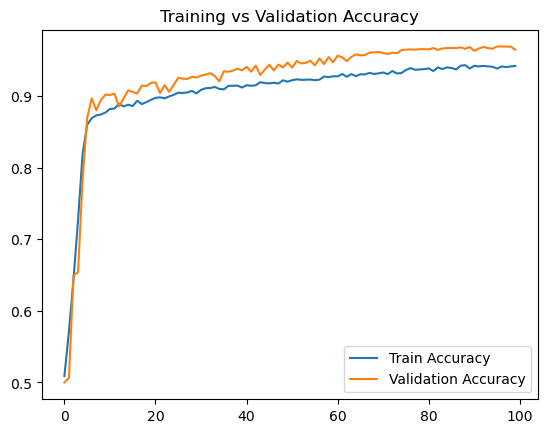

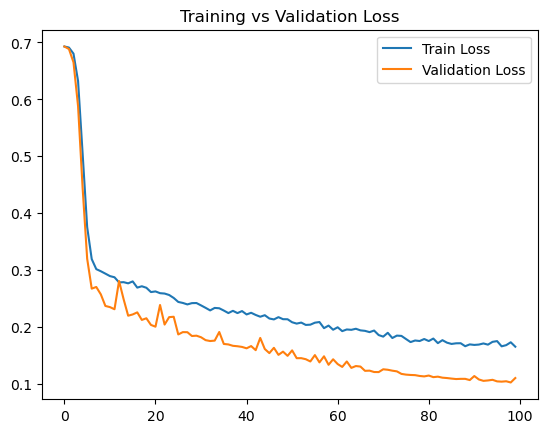

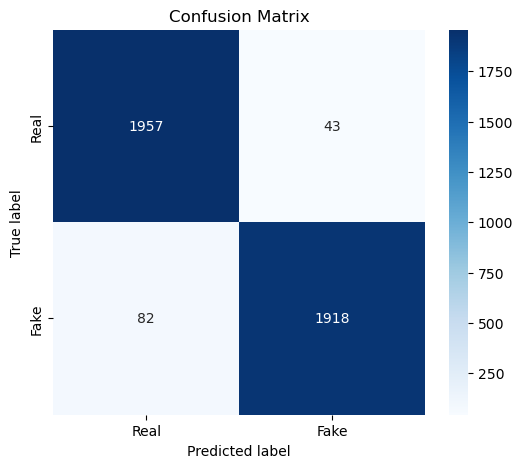

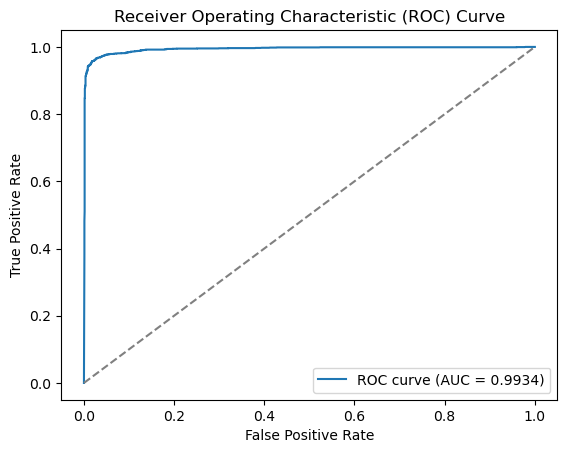

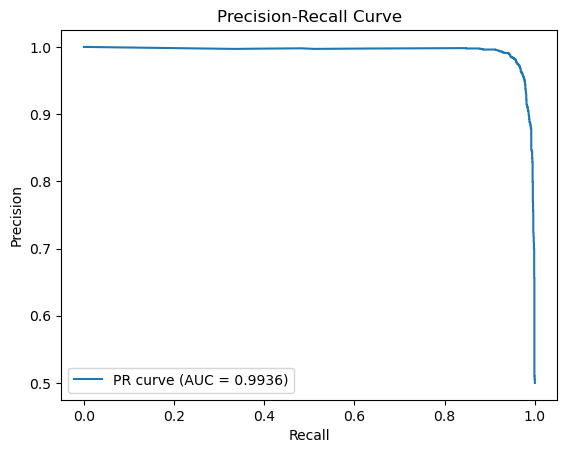

Accuracy Score: 0.9688
ROC AUC Score: 0.9934
Recall Score: 0.9590
Precision Score: 0.9781
F1 Score: 0.9684
PR AUC Score: 0.9936
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2000
           1       0.98      0.96      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



In [9]:
# Train the Model
train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test, epochs=100, batch_size=32)